<a href="https://colab.research.google.com/github/ElenaTratsevskaya/DA-Python-Project-On-Demand/blob/main/%22DA__50_proect_OD_2_%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BF%D1%80%D0%BE%D0%B4%D1%83%D0%BA%D1%82%D0%BE%D0%B2%D0%BE%D0%B9_%D1%84%D0%B8%D1%87%D0%B8_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <span style="font-color:#8B0000;"><div id="header" align="center">ПРОЕКТ On-demand</div></span>

**ЦЕЛЬ**<br>
Оценить эффективность новой фичи в клининговой компании<br><br>

**ЗАДАЧИ**
1. Рассчитать показатели Retention rate (7 дня)  
2. ARPPU за два периода 
3. Сформулировать выводы по выявленным закономерностям.

Период оценки: месяц до внедрения фичи - май 2019 и месяц после внедрения - июнь 2019


In [ ]:
! pip install psycopg2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# importing matplotlib module
import matplotlib.pyplot as plt
plt.style.use('default')

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras 

Для начала необходимо определить количество зарегистрировавшихся пользователей в каждый день мая и июня с помощью функции **getRegisteredUsersCount()**, в которой выполняется SQL-запрос.

Получаем в итоге количество зарегистрировавшихся пользователей registered_users_count за искомый период в разрезе registration_date — дней регистрации.

Конструкция **pd.DataFrame(getRegisteredUsersCount())** позволяет выполнить функцию запроса, а затем записать полученные данные в датафрейм.

In [ ]:
def getRegisteredUsersCount():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-07-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

registered_users_count = pd.DataFrame(getRegisteredUsersCount())

In [ ]:
registered_users_count.head()

,registration_date,registered_users_count
0,2019-05-01,6516
1,2019-05-02,5309
2,2019-05-03,6266
3,2019-05-04,8639
4,2019-05-05,9787


In [ ]:
registered_users_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   registration_date       61 non-null     object
 1   registered_users_count  61 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


Колонка **registration_date** имеет тип *object* (строковая переменная), необходимо её преобразовать в тип *datetime* с помощью метода **pd.to_datetime()**:

In [ ]:
registered_users_count['registration_date'] = pd.to_datetime(registered_users_count['registration_date'])

In [ ]:
registered_users_count.head()

,registration_date,registered_users_count
0,2019-05-01,6516
1,2019-05-02,5309
2,2019-05-03,6266
3,2019-05-04,8639
4,2019-05-05,9787


In [ ]:
# количество пользователей, зарегистрировавшихся в мае и июне
user_count_may = registered_users_count['registered_users_count'][registered_users_count['registration_date']>="2019-05-01"][registered_users_count['registration_date']<"2019-06-01"].sum()
user_count_june = registered_users_count['registered_users_count'][registered_users_count['registration_date']>="2019-06-01"][registered_users_count['registration_date']<"2019-07-01"].sum()
print(f'Количество пользователей, зарегистрировавшихся в мае 2019: {user_count_may}')
print(f'Количество пользователей, зарегистрировавшихся в июне 2019: {user_count_june}') 
print(f'Снижение регистрации пользователей в июне по отношению к маю: {user_count_june-user_count_may}, {round((user_count_june-user_count_may)/(user_count_may)*100, 2)}%')


Количество пользователей, зарегистрировавшихся в мае 2019: 188943
Количество пользователей, зарегистрировавшихся в июне 2019: 100423
Снижение регистрации пользователей в июне по отношению к маю: -88520, -46.85%


Для того чтобы понять сколько пользователей из зарегистрированных впоследствии возвращалось в сервис, необходимо определить количество активных пользователей в разрезе когорт. 

*Примечание*: в качестве когорты будет выступать дата регистрации. Таким образом, определяем количество активных пользователей по дням в разрезе даты регистрации.

Сперва получаем данные об активных пользователях из базы и подсчитаем по дням количество активных пользователей **active_users_count** с указанием даты регистрации **registration_date**.

Создаём функцию **getActiveUsersCountWithCohorts()** и запишем данные, полученные с помощью этой функции, в датафрейм **active_users_count_with_cohorts**.

In [ ]:
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts = pd.DataFrame(getActiveUsersCountWithCohorts())

In [ ]:
active_users_count_with_cohorts.head()

,activity_date,registration_date,active_users_count
0,2019-05-01,2019-05-01,2590
1,2019-05-02,2019-05-01,2146
2,2019-05-02,2019-05-02,2049
3,2019-05-03,2019-05-01,1637
4,2019-05-03,2019-05-02,1817


In [ ]:
active_users_count_with_cohorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891 entries, 0 to 1890
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   activity_date       1891 non-null   object
 1   registration_date   1891 non-null   object
 2   active_users_count  1891 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 44.4+ KB


In [ ]:
# Колонки с датами также имеют тип object, то есть строковый тип. Преобразуем их в тип datetime.
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts[col] = pd.to_datetime(active_users_count_with_cohorts[col])

In [ ]:
active_users_count_with_cohorts.head()

,activity_date,registration_date,active_users_count
0,2019-05-01,2019-05-01,2590
1,2019-05-02,2019-05-01,2146
2,2019-05-02,2019-05-02,2049
3,2019-05-03,2019-05-01,1637
4,2019-05-03,2019-05-02,1817


In [ ]:
# количество активных пользователей по меясцам: май и июнь
user_act_count_may = active_users_count_with_cohorts['active_users_count'][active_users_count_with_cohorts['registration_date']>="2019-05-01"][active_users_count_with_cohorts['registration_date']<"2019-06-01"].sum()
user_act_count_june = active_users_count_with_cohorts['active_users_count'][active_users_count_with_cohorts['registration_date']>="2019-06-01"][active_users_count_with_cohorts['registration_date']<"2019-07-01"].sum()
print(f'Количество активных пользователей в мае 2019: {user_act_count_may}')
print(f'Количество активных пользователей в июне 2019: {user_act_count_june}')
print(f'Снижение активных пользователей в июне по отношению к маю: {user_act_count_june-user_act_count_may}, {round(((user_act_count_june-user_act_count_may)/user_act_count_may)*100, 2)}%') 

Количество активных пользователей в мае 2019: 629192
Количество активных пользователей в июне 2019: 331218
Снижение активных пользователей в июне по отношению к маю: -297974, -47.36%


**ОБЪЕДИНЯЕМ ТАБЛИЦЫ**

1. Таблица с количеством пользователей, которые изначально были в когортах, — это датафрейм **registered_users_count.**<br>
2. Таблица с количеством активных пользователей по дням в каждой когорте — это датафрейм **active_users_count_with_cohorts**.<br>

Объеденяем две таблицы, чтобы рассчитать процент вернувшихся пользователей на определённый день.

In [ ]:
#Объединим таблицы по выбранной колонке и запишем сводные данные в датафрейм retention_table.
retention_table = active_users_count_with_cohorts.merge(registered_users_count,on=['registration_date'],how='left')
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count
0,2019-05-01,2019-05-01,2590,6516
1,2019-05-02,2019-05-01,2146,6516
2,2019-05-02,2019-05-02,2049,5309
3,2019-05-03,2019-05-01,1637,6516
4,2019-05-03,2019-05-02,1817,5309


In [ ]:
retention_table['retention_rate'] = retention_table['active_users_count'] / retention_table['registered_users_count']
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-05-01,2019-05-01,2590,6516,0.397483
1,2019-05-02,2019-05-01,2146,6516,0.329343
2,2019-05-02,2019-05-02,2049,5309,0.385948
3,2019-05-03,2019-05-01,1637,6516,0.251228
4,2019-05-03,2019-05-02,1817,5309,0.342249


В датафрейме **retention_table** необходимо определить, какое количество дней прошло с момента регистрации до определённого дня активности.

In [ ]:
retention_table['lifetime'] = retention_table['activity_date'] - retention_table['registration_date']
retention_table['lifetime'].head()

0   0 days
1   1 days
2   0 days
3   2 days
4   1 days
Name: lifetime, dtype: timedelta64[ns]

Но **timedelta** при вычитании одной даты из другой будет подсчитана в днях. Это видно по типу данных в колонке **timedelta64[ns]**.

Нам нужно получить целое количество дней, поэтому значения в колонке с типом timedelta мы разделим на константу **np.timedelta64(1,'D')**:

In [ ]:
retention_table['lifetime'] = retention_table['lifetime']/np.timedelta64(1,'D')
retention_table['lifetime'] = retention_table['lifetime'].astype(int)
# Приведем тип к целому числу retention_table['lifetime'].head()

**ФОРМИРУЕМ СВОДНУЮ ТАБЛИЦУ**

In [ ]:
# Сформируем сводную таблицу retention_pivot.
retention_pivot = retention_table.pivot_table(
    index='registration_date',
    columns='lifetime',
    values='retention_rate',
    aggfunc='sum')
retention_pivot.head()

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,0.397483,0.329343,0.251228,0.222683,0.198895,0.174954,0.153929,0.146255,0.133671,0.123082,...,0.072284,0.069828,0.068754,0.067219,0.067373,0.063536,0.062922,0.060773,0.043738,0.029619
2019-05-02,0.385948,0.342249,0.254285,0.219062,0.193633,0.164061,0.152006,0.140328,0.125071,0.117160,...,0.067056,0.059522,0.059898,0.061217,0.060652,0.058768,0.055943,0.053682,0.045018,0.031456
2019-05-03,0.381264,0.339291,0.256783,0.219438,0.188477,0.170124,0.148899,0.142834,0.132301,0.126716,...,0.071976,0.070859,0.072455,0.069103,0.067028,0.066550,0.063837,0.060166,0.046920,0.030961
2019-05-04,0.384651,0.335224,0.241232,0.191573,0.169348,0.150249,0.140178,0.137284,0.131728,0.116796,...,0.072925,0.071420,0.066906,0.065401,0.064012,0.061465,0.058456,0.057646,0.043176,0.029286
2019-05-05,0.383161,0.311944,0.227751,0.192398,0.170737,0.152549,0.145397,0.138755,0.121488,0.113518,...,0.067641,0.063962,0.061101,0.060693,0.058547,0.057014,0.053438,0.054256,0.043936,0.027179


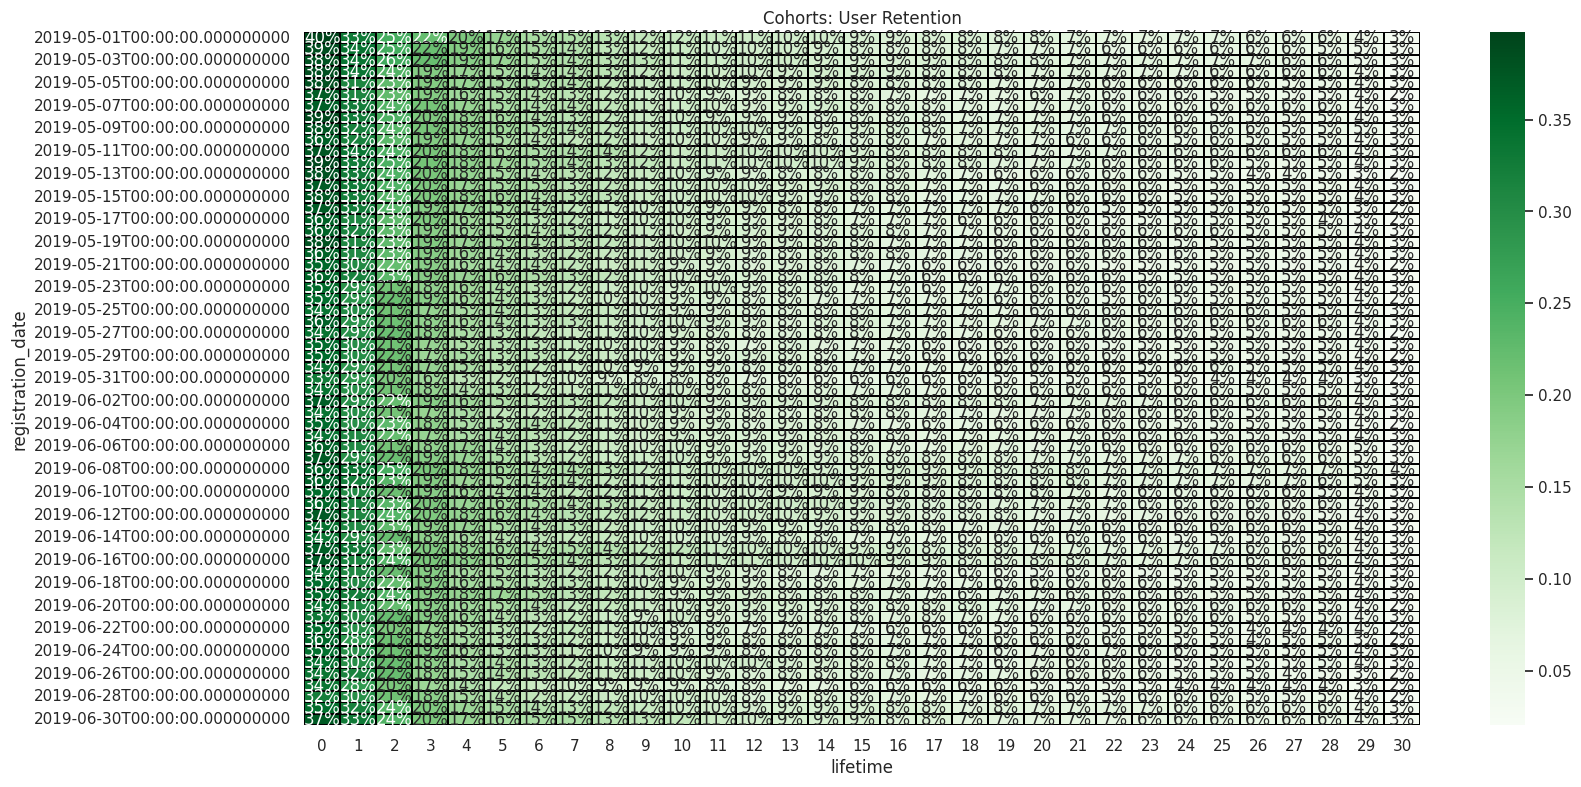

In [ ]:
#Такую таблицу удобно визуализировать с помощью heatmap в библиотеке seaborn:

import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style='white')
plt.figure(figsize=(18, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, mask=retention_pivot.isnull(), annot=True, fmt='.0%', linewidths=0.5, linecolor='black', cmap="Greens");

**ОЦЕНИВАЕМ ИЗМЕНЕНИЯ RETENTION RATE НА СЕДЬМОЙ ДЕНЬ**


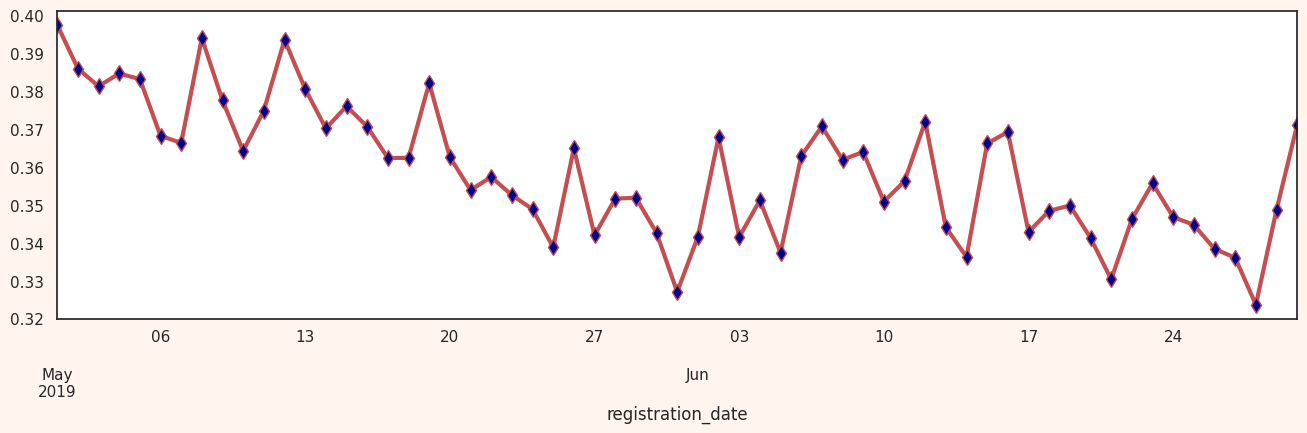

In [ ]:
#С помощью retention_pivot удобно визуализировать изменения Retention Rate по каждой когорте с течением времени. 
# Посмотрим, как в зависимости от когорты изменяется Retention Rate на нулевой день.
fig = plt.figure(figsize=(16, 4))
fig.set_facecolor('seashell')
retention_pivot[0].plot(color= "r", ms=8, marker='d', markerfacecolor='darkblue', linewidth=3)

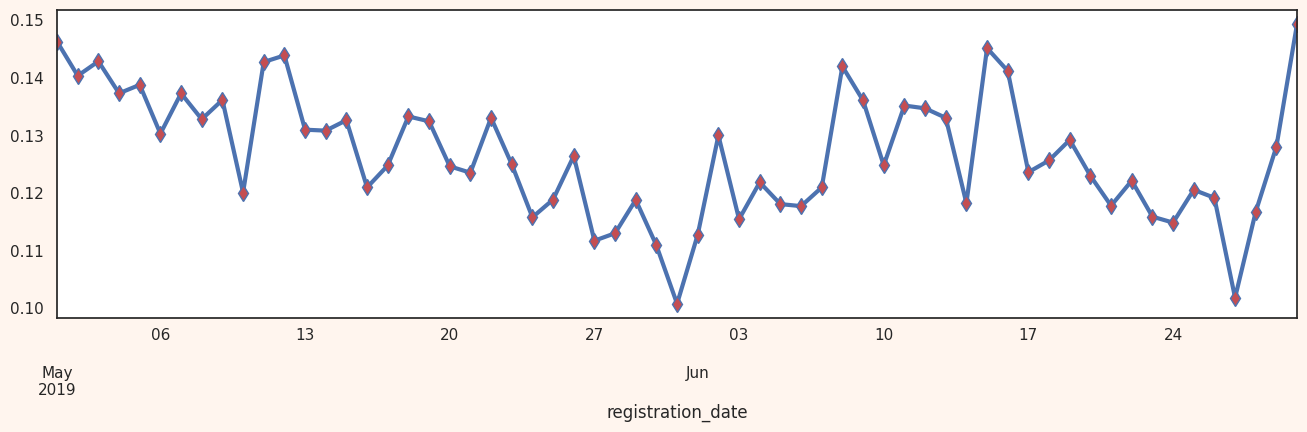

In [ ]:
# Посмотрим, как в зависимости от когорты изменяется Retention Rate на седьмой день.
fig = plt.figure(figsize=(16, 4))
fig.set_facecolor('seashell')
retention_pivot[7].plot(ms=8, marker='d', markerfacecolor='r', linewidth=3)

Первый график демонстрирует снижение в мае на конец месяца, во втором эта динамика ещё более выражена. А в июне на конец месяца - рост.

Найдём относительное изменение Retention Rate на седьмой день для когорты 31 мая 2019 года относительно когорты 1 мая 2019 года и для когорты 30 июня 2019 года относительно когорты 1 июня 2019 года.

In [ ]:
rr_may = retention_pivot[7]['2019-05-31']/retention_pivot[7]['2019-05-01']
rr_june = retention_pivot[7]['2019-06-30']/retention_pivot[7]['2019-06-01']
print(f'Отношение возвращаемости на 7 день для когорты 31 мая 2019 относительно когорты 1 мая 2019 года: {round(rr_may*100, 2)}%')
print(f'Динамика по маю: {round(((rr_may - 1)*100), 2)}%')
print(f'Отношение возвращаемости на 7 день для когорты конца относительно когорты начала месяца в июне: {round(rr_june*100, 3)}%')
print(f'Динамика по июню: {round(((rr_june - 1)*100), 2)}%')

Отношение возвращаемости на 7 день для когорты 31 мая 2019 относительно когорты 1 мая 2019 года: 68.89%
Динамика по маю: -31.11%
Отношение возвращаемости на 7 день для когорты конца относительно когорты начала месяца в июне: 132.441%
Динамика по июню: 32.44%


**СЧИТАЕМ ВЫРУЧКУ ПО ДНЯМ**


В датафрейме **retention_table** хранится информация об активных пользователях.

Чтобы посчитать ARPU, не хватает информации о выручке по дням, разбитой на когорты.

С помощью SQL-запроса получим выручку по дням в разрезе когорт для пользователей, зарегистрировавшихся в мае и июне 2019 года. Этот запрос обернём в функцию getRevenue(), после чего получим данные по запросу и запишем в датафрейм **revenue**.

In [ ]:
def getRevenue():
    query = '''SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data
revenue = pd.DataFrame(getRevenue())

In [ ]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1745 entries, 0 to 1744
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      1745 non-null   datetime64[ns]
 1   registration_date         1745 non-null   datetime64[ns]
 2   users_count_with_revenue  1745 non-null   int64         
 3   revenue                   1745 non-null   float64       
dtypes: datetime64[ns](2), float64(1), int64(1)
memory usage: 54.7 KB


In [ ]:
for col in ['date','registration_date']:
    revenue[col] = pd.to_datetime(revenue[col])

In [ ]:
revenue.head()

,date,registration_date,users_count_with_revenue,revenue
0,2019-05-01,2019-05-01,1672,2357.580
1,2019-05-02,2019-05-01,1420,514.679
2,2019-05-02,2019-05-02,1367,1629.140
3,2019-05-03,2019-05-01,1048,390.952
4,2019-05-03,2019-05-02,1164,533.608


In [ ]:
revenue_may = revenue['revenue'][revenue['registration_date']>="2019-05-01"][revenue['registration_date']<"2019-06-01"].sum()
revenue_june = revenue['revenue'][revenue['registration_date']>="2019-06-01"][revenue['registration_date']<"2019-07-01"].sum()
print(f'Выручка за май 2019 года: {round(revenue_may, 2)}')
print(f'Выручка за июнь 2019 года: {round(revenue_june, 2)}')
print(f'Снижение выручки в июне по отношению к маю 2019 года: {round(revenue_june-revenue_may, 2)}, {round(((revenue_june-revenue_may)/revenue_may)*100, 2)}%')

Выручка за май 2019 года: 121998.3
Выручка за июнь 2019 года: 79685.87
Снижение выручки в июне по отношению к маю 2019 года: -42312.43, -34.68%


**СЧИТАЕМ СРЕДНЮЮ ВЫРУЧКУ**

In [ ]:
mean_rev_may = revenue_may/user_count_may
mean_rev_june = revenue_june/user_count_june
print(f'Cредняя выручка за месяц с пользователей, зарегистрировавшихся в мае: {round(mean_rev_may, 2)}')
print(f'Cредняя выручка за месяц с пользователей, зарегистрировавшихся в июне: {round(mean_rev_june, 2)}')
print(f'Рост средней выручки с пользователя: {round(mean_rev_june-mean_rev_may, 2)}, {round(((mean_rev_june-mean_rev_may)/mean_rev_may)*100, 2)}%')

Cредняя выручка за месяц с пользователей, зарегистрировавшихся в мае: 0.65
Cредняя выручка за месяц с пользователей, зарегистрировавшихся в июне: 0.79
Рост средней выручки с пользователя: 0.15, 22.89%


<span style="color:red">**В Ы В О Д Ы**<span> <span style="color:#000000">(промежуточные)<span><br>
На данном этапе получен следующий информационный срез:
<blockquote>
<p>Количество зарегистрировавшихся пользователей за май 2019 года: 18 8943<br>
Количество зарегистрировавшихся пользователей за июнь 2019 года: 10 0423<br>
Снижение регистрации пользователей в июне по отношению к маю: -8 8520, на 46.85%<br>

Количество активных пользователей в мае 2019: 629192<br>
Количество активных пользователей в июне 2019: 331218<br>
Снижение активных пользователей в июне по отношению к маю: -297974, на 47.36%<br>

Отношение возвращаемости на конец и начало месяца в мае: 68.89%<br>
Динамика по маю: -31.11%<br>
Отношение возвращаемости на конец и начало месяца в июне: 132.441%<br>
Динамика по июню: 32.44%<br>

Выручка за май 2019 года: 121 998.3<br>
Выручка за июнь 2019 года: 79 685.87<br>
Снижение выручки в июне по отношению к маю 2019 года: -42 312.43, на 34.68%

Cредняя выручка за месяц с пользователей, зарегистрировавшихся в мае: 0.65<br>
Cредняя выручка за месяц с пользователей, зарегистрировавшихся в июне: 0.79<br>
Рост средней выручки с пользователя в июне по отношению к маю: 0.15, на 22.89%<br>

*   Не смотря на снижение числа зарегистрированных пользователей и суммарной выручки по месяцам, средняя выручка от пользователя в июне увеличилась по отношению к маю. Возможно это связано с увеличением тарифа.
*   Отношение возвращаемостей по месяцам демонстриует полодительную динамику в июне



*Точной информации о тарифах для пользователей в исходных данных нет.*
<p>

**ОБЪЕДИНЯЕМ ДАТАФРЕЙМЫ**

Следующий шаг — объединение данных из датафрейма **revenue** с данными из датафрейма **retention_table**. 

Но прежде в датафрейме **revenue** следует изменить название колонки **date** на a**ctivity_date**. Делаем это с тем, чтобы в дальнейшем объединять датафреймы по одинаковому названию колонок.

In [ ]:
revenue = revenue.rename(columns={'date':'activity_date'})

In [ ]:
#После переименования можно объединить датафреймы в новый датафрейм retention_table_with_revenue.
retention_table_with_revenue = retention_table.merge(revenue,on=['registration_date','activity_date'],how='left')

In [ ]:
retention_table_with_revenue.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue
0,2019-05-01,2019-05-01,2590,6516,0.397483,0,1672.0,2357.580
1,2019-05-02,2019-05-01,2146,6516,0.329343,1,1420.0,514.679
2,2019-05-02,2019-05-02,2049,5309,0.385948,0,1367.0,1629.140
3,2019-05-03,2019-05-01,1637,6516,0.251228,2,1048.0,390.952
4,2019-05-03,2019-05-02,1817,5309,0.342249,1,1164.0,533.608


In [ ]:
retention_table_with_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1891 entries, 0 to 1890
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   activity_date             1891 non-null   datetime64[ns]
 1   registration_date         1891 non-null   datetime64[ns]
 2   active_users_count        1891 non-null   int64         
 3   registered_users_count    1891 non-null   int64         
 4   retention_rate            1891 non-null   float64       
 5   lifetime                  1891 non-null   int64         
 6   users_count_with_revenue  1745 non-null   float64       
 7   revenue                   1745 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(3)
memory usage: 133.0 KB


In [ ]:
#Замена пропущенных значений на 0 с помощью функции fillna().
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue[col] = retention_table_with_revenue[col].fillna(0)

In [ ]:
#Преобразуем тип в колонке users_count_with_revenue в целочисленный.
retention_table_with_revenue['users_count_with_revenue'] = retention_table_with_revenue['users_count_with_revenue'].astype(int)

In [ ]:
retention_table_with_revenue['arpu'] = retention_table_with_revenue['revenue'] / retention_table_with_revenue['active_users_count']
retention_table_with_revenue.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue,arpu
0,2019-05-01,2019-05-01,2590,6516,0.397483,0,1672,2357.580,0.910263
1,2019-05-02,2019-05-01,2146,6516,0.329343,1,1420,514.679,0.239832
2,2019-05-02,2019-05-02,2049,5309,0.385948,0,1367,1629.140,0.795090
3,2019-05-03,2019-05-01,1637,6516,0.251228,2,1048,390.952,0.238822
4,2019-05-03,2019-05-02,1817,5309,0.342249,1,1164,533.608,0.293675


In [ ]:
retention_table_with_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1891 entries, 0 to 1890
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   activity_date             1891 non-null   datetime64[ns]
 1   registration_date         1891 non-null   datetime64[ns]
 2   active_users_count        1891 non-null   int64         
 3   registered_users_count    1891 non-null   int64         
 4   retention_rate            1891 non-null   float64       
 5   lifetime                  1891 non-null   int64         
 6   users_count_with_revenue  1745 non-null   float64       
 7   revenue                   1745 non-null   float64       
dtypes: datetime64[ns](2), float64(3), int64(3)
memory usage: 197.5 KB


Считаем пользователей, выполнивших оплату в мае и июне.<br>
Эти данные понадобятся для расчёта ARPPU.


In [ ]:
user_count_revenue_may = retention_table_with_revenue['users_count_with_revenue'][retention_table_with_revenue['registration_date']>="2019-05-01"][retention_table_with_revenue['registration_date']<"2019-06-01"].sum()
user_count_revenue_june = retention_table_with_revenue['users_count_with_revenue'][retention_table_with_revenue['registration_date']>="2019-06-01"][retention_table_with_revenue['registration_date']<"2019-07-01"].sum()
print(f'Колличество пользователей по показателю user_count_revenue_may: {user_count_revenue_may}') 
print(f'Колличество пользователей по показателю user_count_revenue_june: {user_count_revenue_june}')

Колличество пользователей по показателю user_count_revenue_may: 398525.0
Колличество пользователей по показателю user_count_revenue_june: 202663.0


Разделяем таблицу таблицу на 2 периода : май 2019 и июнь 2019 (поскольку изначальный запрос содержит оба месяца) и вводим условие 'lifetime' = 7 дней.

In [ ]:
retention_7_may_table = retention_table_with_revenue[retention_table_with_revenue['lifetime']==7][retention_table_with_revenue['registration_date']>="2019-05-01"][retention_table_with_revenue['registration_date']<"2019-06-01"]
retention_7_may_table.head()

<ipython-input-56-7f2647d2bdcd>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retention_7_may_table = retention_table_with_revenue[retention_table_with_revenue['lifetime']==7][retention_table_with_revenue['registration_date']>="2019-05-01"][retention_table_with_revenue['registration_date']<"2019-06-01"]


,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue
28,2019-05-08,2019-05-01,953,6516,0.146255,7,616.0,63.9066
37,2019-05-09,2019-05-02,745,5309,0.140328,7,490.0,313.7230
47,2019-05-10,2019-05-03,895,6266,0.142834,7,571.0,110.7260
58,2019-05-11,2019-05-04,1186,8639,0.137284,7,750.0,124.8590
70,2019-05-12,2019-05-05,1358,9787,0.138755,7,885.0,174.9240


In [ ]:
retention_7_june_table = retention_table_with_revenue[retention_table_with_revenue['lifetime']==7][retention_table_with_revenue['registration_date']>="2019-06-01"][retention_table_with_revenue['registration_date']<"2019-07-01"]
retention_7_june_table.head()

<ipython-input-57-d06bb8139afa>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  retention_7_june_table = retention_table_with_revenue[retention_table_with_revenue['lifetime']==7][retention_table_with_revenue['registration_date']>="2019-06-01"][retention_table_with_revenue['registration_date']<"2019-07-01"]


,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue
736,2019-06-08,2019-06-01,545,4833,0.112766,7,365.0,176.3160
767,2019-06-09,2019-06-02,683,5255,0.129971,7,461.0,193.8390
798,2019-06-10,2019-06-03,484,4193,0.115430,7,320.0,27.7548
829,2019-06-11,2019-06-04,511,4194,0.121841,7,320.0,54.9610
860,2019-06-12,2019-06-05,472,3998,0.118059,7,301.0,63.1554


Визуализируем данные по **retention_rate** по месяцам для наглядности.

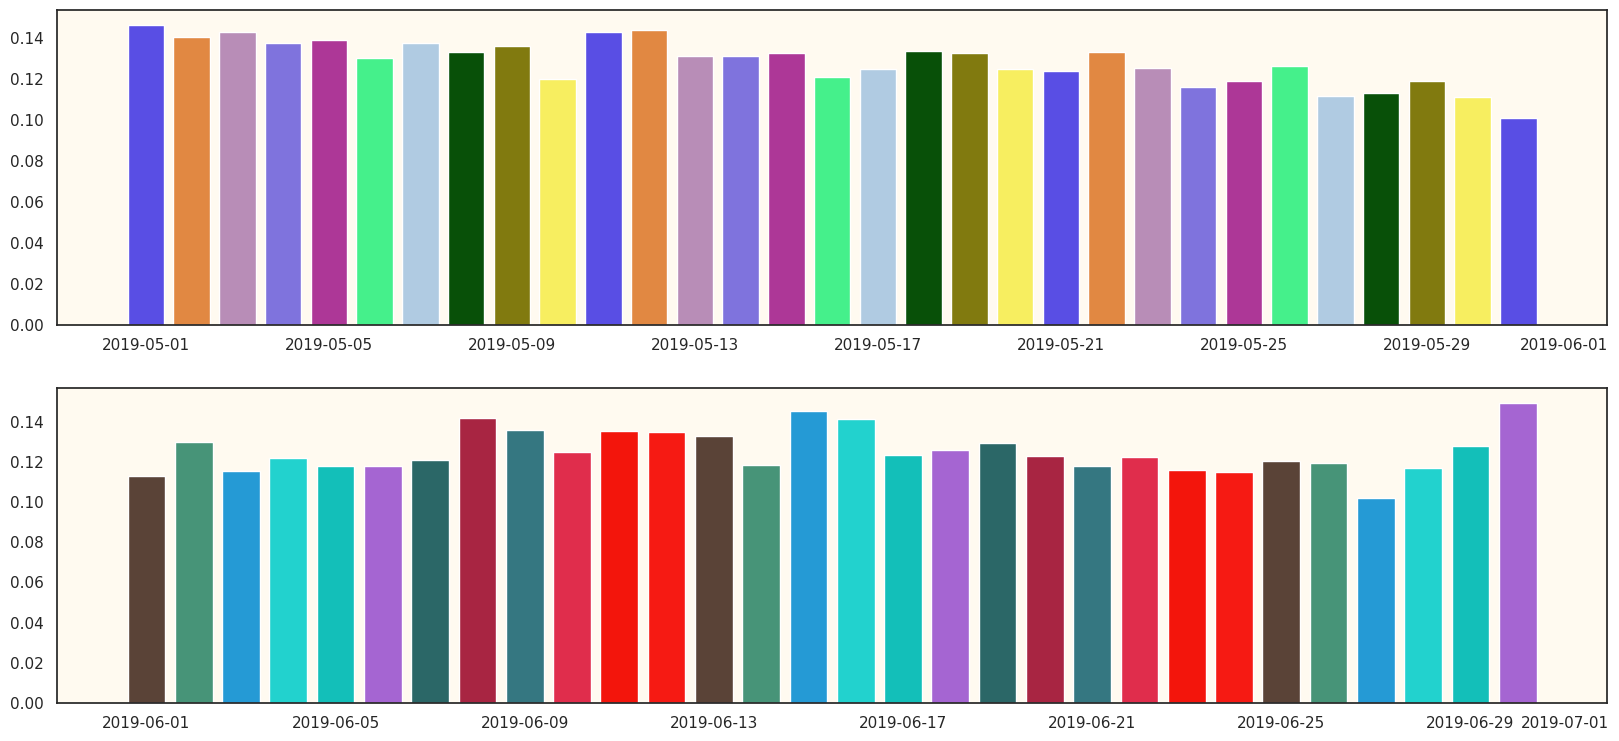

In [ ]:
x1 = retention_7_may_table['registration_date']
y1 = retention_7_may_table['retention_rate']
x2 = retention_7_june_table['registration_date']
y2 = retention_7_june_table['retention_rate']

fig, axes = plt.subplots(2, 1)

axes[0].set_facecolor('floralwhite')
axes[1].set_facecolor('floralwhite')
color_rectangle = np.random.rand(10, 3)    # RGB
axes[0].bar(x1, y1, color = color_rectangle)
color_rectangle = np.random.rand(12, 3)    # RGB
axes[1].bar(x2, y2, color = color_rectangle)

#fig.set_facecolor('floralwhite')
fig.set_figwidth(20)    #  ширина Figure
fig.set_figheight(9)    #  высота Figure

plt.show()

Из полученных таблиц извлекам искомые показатели.

In [ ]:
retention_7_may = (retention_7_may_table['active_users_count'].sum()/retention_7_may_table['registered_users_count'].sum())*100
retention_7_june = (retention_7_june_table['active_users_count'].sum()/retention_7_june_table['registered_users_count'].sum())*100
print(f'Retention rate за май 2019: {round(retention_7_may, 2)}%')
print(f'Retention rate за июнь 2019: {round(retention_7_june, 2)}%')
print(f'Динамика: {round(retention_7_june-retention_7_may, 2)}%')

Retention rate за май 2019: 12.93%
Retention rate за июнь 2019: 12.56%
Динамика: -0.37%


In [ ]:
arppu_may = revenue_may/user_count_revenue_may
arppu_june = revenue_june/retention_table_with_revenue['users_count_with_revenue'][retention_table_with_revenue['registration_date']>="2019-06-01"][retention_table_with_revenue['registration_date']<"2019-07-01"].sum()
print(f'ARPPU за май 2019: {round(arppu_may, 2)}')
print(f'ARPPU за июнь 2019: {round(arppu_june, 2)}')
print(f'Динамика: {round((arppu_june/arppu_may - 1)*100, 2)}%')

ARPPU за май 2019: 0.31
ARPPU за июнь 2019: 0.39
Динамика: 28.44%


# <div id="header" align="center"><span style="color:red">**В Ы В О Д Ы**<span> <span style="color:#000000"><span></div>
<blockquote>
<p><h1><table>
<thead>
<tr><th><h1>Показатель/месяц</h1></th><th><h1>май 2019</h1></th><th><h1>июнь 2019</h1></th><th><h1>Динамика</h1></th></tr>
</thead>
<tbody>
<tr><td><h1>Retention rate</h1></td><td><h1>12.93%</h1></td><td><h1>12.56%</h1></td><th><h1>-0.37%</h1></th></tr>
<tr><td><h1>ARPPU</td><td></h1><h1>0.31</h1></td><td><h1>0.39</h1></td><th><h1>28.44%</h1></th></tr>
</tbody>
</table></h1>
<p>


<blockquote>
<p>Ввод новой фичи практически не изменил показатель возвращаемости клиентов, колебания в сотых процента, при этом рост ARPPU демонстрирует заметную положительную динамику. 

У нас отсутствуют данные затрат на создание новой фичи, трудно делать выводы о рентабельности данной разработки. Возможно необходимо снятие показателей в следующие за июнем месяцы. Но фича работает, пользователь остаётся на платформе.</p>